In [1]:
import numpy as np
from numpy.random import randn, rand, normal, uniform, randint
from numpy import nan as NA  # np.nan
import pandas as pd
import matplotlib.pyplot as plt  # Matplotlib绘图
from matplotlib import style
from scipy import stats
import seaborn as sns  # Seaborn绘图
import re

np.set_printoptions(suppress=True)  # 取消小数默认使用科学记数法
np.set_printoptions(precision=4)  # 设置小数精度
pd.options.display.max_rows = 10  # 设置数据显示的最大行数

In [20]:
train_data = pd.read_csv("datalab/1386/train.csv")
test_data = pd.read_csv("datalab/1386/test.csv")

sns.set_style("whitegrid")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [58]:
# 利用中位数填充Age
train_data["Age"] = train_data["Age"].fillna(train_data["Age"].median())
test_data["Age"] = test_data["Age"].fillna(test_data["Age"].median())
# 众数
train_data["Embarked"] = train_data["Embarked"].fillna(train_data["Embarked"].mode())
test_data["Embarked"] = test_data["Embarked"].fillna(test_data["Embarked"].mode())

In [121]:
# 数字化
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Embarked"]
train_data_gd = pd.get_dummies(train_data[features])
test_data_gd = pd.get_dummies(test_data[features])

In [122]:
train_data_gd.tail()

,Pclass,SibSp,Parch,Sex_female,Sex_male
886,2,0,0,0,1
887,1,0,0,1,0
888,3,1,2,1,0
889,1,0,0,0,1
890,3,0,0,0,1


In [123]:
y = train_data.loc[:, "Survived"]
y.shape

(891,)

In [124]:
X = train_data_gd
X.shape

(891, 5)

In [125]:
# 建立预测模型
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=123)

In [82]:
from sklearn.model_selection import KFold
# 比较不同模型
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

In [126]:
clf1 = DecisionTreeClassifier()
clf1.fit(train_X, train_y)

clf2 = SVC(probability=True, gamma='auto')
clf2.fit(train_X, train_y)

clf3 = LogisticRegression(solver='liblinear', multi_class='auto')
clf3.fit(train_X, train_y)

clf4 = RandomForestClassifier(n_estimators=500, warm_start=True, max_features="sqrt", max_depth=6, 
                            min_samples_split=3, min_samples_leaf=2, n_jobs=-1, verbose=0)
clf4.fit(train_X, train_y)

clf5 = XGBClassifier(n_estimators=200, max_depth=4, min_child_weight=2, gamma=0.9, subsample=0.8,
                    colsample_bytree=0.8, objective="binary:logistic", nthread=-1, scale_pos_weight=1)
clf5.fit(train_X, train_y)

clf6 = AdaBoostClassifier(n_estimators=500, learning_rate=0.1)
clf6.fit(train_X, train_y)

clf7 = ExtraTreesClassifier(n_estimators=500, n_jobs=-1, max_depth=8, min_samples_leaf=2, verbose=0)
clf7.fit(train_X, train_y)

clf8 = GradientBoostingClassifier(n_estimators=500, learning_rate=0.008, min_samples_split=3, min_samples_leaf=2, max_depth=5, verbose=0)
clf8.fit(train_X, train_y)

clf9 = KNeighborsClassifier(n_neighbors=2)
clf9.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

C:\Program Files\Python37\Lib\site-packages\sklearn\ensemble\_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


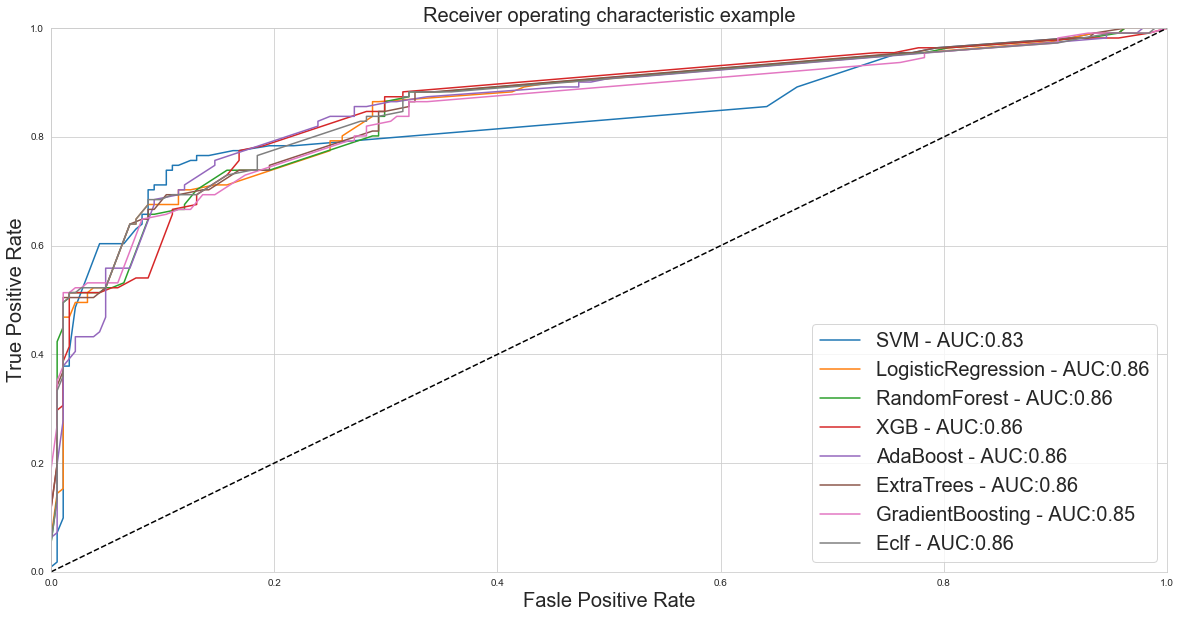

In [127]:
plt.figure(figsize=[20, 10])
li_clfs = [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9]
li_names = ['Decision Tree', 'SVM', 'LogisticRegression', 'RandomForest', "XGB",
            "AdaBoost", "ExtraTrees", "GradientBoosting", "KNeighbors"]
eclf = VotingClassifier(estimators=list(zip(li_names, li_clfs)), voting="soft")
li_clfs.append(eclf)
li_names.append("Eclf")
for clf, title in zip(li_clfs, li_names):
    probas_ = clf.fit(train_X, train_y).predict_proba(test_X)
    fpr, tpr, thresholds = roc_curve(test_y, probas_[:, 1])
    plt.plot(fpr, tpr, label=f'{title} - AUC:{auc(fpr, tpr):.2f}')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Fasle Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver operating characteristic example', fontsize=20)
plt.legend(loc='lower right', fontsize=20)
plt.show()

In [100]:
# 预测
predictions = eclf.predict(test_data_gd)

# 输出预测并保存为本地文件
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission_for_titanic_20200702002.csv', index=False)